sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
       0    1    2    3    4    5     6    7      8    9     10     11  \
0  1923.0  0.0  0.5  1.0  7.0  0.0  46.0  0.5  191.0  1.0  10.0  767.0   
1   633.0  1.0  2.2  0.0  0.0  1.0  49.0  0.1  139.0  8.0   1.0  529.0   
2  1236.0  0.0  0.9  1.0  2.0  1.0  57.0  0.1  188.0  1.0  14.0  517.0   
3   781.0  0.0  1.1  0.0  2.0  0.0  38.0  0.4  198.0  5.0   7.0  304.0   
4  1456.0  1.0  0.5  1.0  7.0  0.0   7.0  0.4  105.0  5.0  12.0  823.0   

       12      13    14    15    16   17   18   19  
0  1759.0  1489.0  10.0   9.0   3.0  1.0  1.0  1.0  
1  1009.0  3560.0  11.0   1.0  16.0  1.0  1.0  1.0  
2   809.0  1406.0  14.0  12.0  20.0  1.0  0.0  1.0  
3  1674.0  3508.0  13.0   8.0   5.0  0.0  0.0  1.0  
4  1104.0  1587.0   6.0   5.0  20.0  1.0  0.0  1.0  
                0            1 

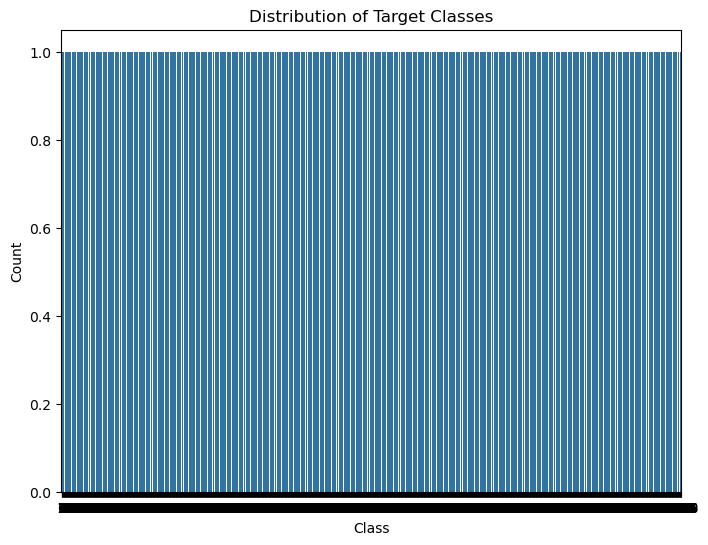

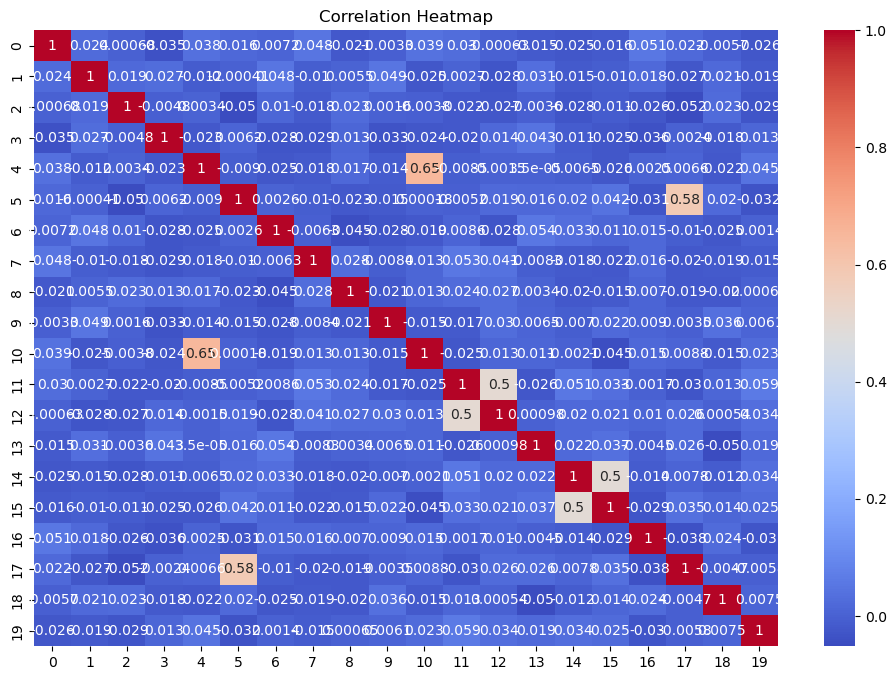

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_svmlight_file
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

# Define the SageMaker session and role
sagemaker_session = sagemaker.Session()
role = get_execution_role()

# Load the libsvm formatted data
X_train, y_train = load_svmlight_file('train.libsvm')
X_test, y_test = load_svmlight_file('test.libsvm')

# Load feature names if available
# Replace 'feature_names.npy' with the actual file name if available
try:
    feature_names = np.load('feature_names.npy')
except FileNotFoundError:
    feature_names = None

# Convert the data to DataFrames for exploration
train_df = pd.DataFrame(X_train.toarray(), columns=feature_names)
test_df = pd.DataFrame(X_test.toarray(), columns=feature_names)

# Display the first few rows of the DataFrame
print(train_df.head())

# Display summary statistics of the DataFrame
print(train_df.describe())

# Check for missing values
print(train_df.isnull().sum())

# Visualize the distribution of target classes
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(y_train)
plt.title('Distribution of Target Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Correlation heatmap
correlation_matrix = train_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [4]:
# Calculate correlations between features and target variable
correlations = train_df.corrwith(pd.Series(y_train))

# Sort the correlations in descending order
sorted_correlations = correlations.abs().sort_values(ascending=False)

# Select the top k features (e.g., top 5)
top_k_features = sorted_correlations.head(5).index.tolist()

print("Top 5 features with highest correlation with target variable:")
print(top_k_features)


Top 5 features with highest correlation with target variable:
[13, 0, 12, 11, 6]


In [5]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_svmlight_file, dump_svmlight_file
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

# Define the SageMaker session and role
sagemaker_session = sagemaker.Session()
role = get_execution_role()

# Load the libsvm formatted data
X_train, y_train = load_svmlight_file('train.libsvm')
X_test, y_test = load_svmlight_file('test.libsvm')

# Select the specific features
selected_features = [13, 0, 12, 11, 6]

# Subset the training and test data to include only selected features
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Save the modified training data to a libsvm formatted file
dump_svmlight_file(X_train_selected, y_train, 'train_selected.libsvm')

# Save the modified test data to a libsvm formatted file
dump_svmlight_file(X_test_selected, y_test, 'test_selected.libsvm')

# Define the prefix for S3 key prefix
prefix_selected = 'xgboost-classification-selected'

# Upload the modified data to S3
train_data_selected_location = sagemaker_session.upload_data(path='train_selected.libsvm', key_prefix=prefix_selected + '/input/train_selected')
test_data_selected_location = sagemaker_session.upload_data(path='test_selected.libsvm', key_prefix=prefix_selected + '/input/test_selected')

# Get the XGBoost container
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')

# Define the estimator
estimator_selected = sagemaker.estimator.Estimator(container,
                                                    role,
                                                    train_instance_count=1,
                                                    train_instance_type='ml.m4.xlarge',
                                                    output_path='s3://{}/{}/output_selected'.format(sagemaker_session.default_bucket(), prefix_selected))

# Set hyperparameters
estimator_selected.set_hyperparameters(max_depth=5,
                                        eta=0.2,
                                        gamma=4,
                                        min_child_weight=6,
                                        subsample=0.8,
                                        silent=0,
                                        objective='multi:softmax',
                                        num_class=4,
                                        num_round=1000)

# Train the model with selected features
estimator_selected.fit({'train': train_data_selected_location})

# Deploy the model with selected features
predictor_selected = estimator_selected.deploy(initial_instance_count=1,
                                                instance_type='ml.m4.xlarge')

# Make predictions with the deployed model
predictions_selected = predictor_selected.predict(data=X_test_selected)


The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
INFO:sagemaker:Creating training-job with name: xgboost-2024-04-22-09-41-45-618


2024-04-22 09:41:45 Starting - Starting the training job...
2024-04-22 09:42:00 Starting - Preparing the instances for training...
2024-04-22 09:42:39 Downloading - Downloading input data......
2024-04-22 09:43:19 Downloading - Downloading the training image...
2024-04-22 09:44:05 Training - Training image download completed. Training in progress...Arguments: train
[2024-04-22:09:44:18:INFO] Running standalone xgboost training.
[2024-04-22:09:44:18:INFO] Path /opt/ml/input/data/validation does not exist!
[2024-04-22:09:44:18:INFO] File size need to be processed in the node: 0.05mb. Available memory size in the node: 8482.66mb
[09:44:18] S3DistributionType set as FullyReplicated
[09:44:18] 1600x5 matrix with 7998 entries loaded from /opt/ml/input/data/train
[09:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 12 pruned nodes, max_depth=4
[09:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 8 pruned nodes, max_depth=5
[09:44:1


2024-04-22 09:44:41 Uploading - Uploading generated training model
2024-04-22 09:44:41 Completed - Training job completed


INFO:sagemaker:Creating model with name: xgboost-2024-04-22-09-44-58-033


Training seconds: 122
Billable seconds: 122


INFO:sagemaker:Creating endpoint-config with name xgboost-2024-04-22-09-44-58-033
INFO:sagemaker:Creating endpoint with name xgboost-2024-04-22-09-44-58-033


-----!

ParamValidationError: Parameter validation failed:
Invalid type for parameter Body, value:   (0, 1)	1646.0
  (0, 4)	25.0
  (0, 3)	211.0
  (0, 2)	1608.0
  (0, 0)	686.0
  (1, 1)	1182.0
  (1, 4)	8.0
  (1, 3)	275.0
  (1, 2)	986.0
  (1, 0)	2563.0
  (2, 1)	1972.0
  (2, 4)	14.0
  (2, 3)	293.0
  (2, 2)	952.0
  (2, 0)	1316.0
  (3, 1)	989.0
  (3, 4)	17.0
  (3, 3)	256.0
  (3, 2)	1394.0
  (3, 0)	3892.0
  (4, 1)	615.0
  (4, 4)	58.0
  (4, 3)	1021.0
  (4, 2)	1958.0
  (4, 0)	1906.0
  :	:
  (395, 1)	1379.0
  (395, 4)	19.0
  (395, 3)	387.0
  (395, 2)	671.0
  (395, 0)	3912.0
  (396, 1)	991.0
  (396, 4)	12.0
  (396, 3)	1209.0
  (396, 2)	1678.0
  (396, 0)	2014.0
  (397, 1)	1044.0
  (397, 4)	12.0
  (397, 3)	1230.0
  (397, 2)	1263.0
  (397, 0)	1794.0
  (398, 1)	728.0
  (398, 4)	25.0
  (398, 3)	526.0
  (398, 2)	1529.0
  (398, 0)	2039.0
  (399, 1)	1185.0
  (399, 4)	31.0
  (399, 3)	837.0
  (399, 2)	1642.0
  (399, 0)	2447.0, type: <class 'scipy.sparse._csr.csr_matrix'>, valid types: <class 'bytes'>, <class 'bytearray'>, file-like object

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have defined X_train and y_train
# Load the training data into a DataFrame for exploration
train_df = pd.DataFrame(X_train.toarray())  # Convert X_train to a DataFrame if it's a sparse matrix

# Display the first few rows of the DataFrame
print(train_df.head())

# Display summary statistics of the DataFrame
print(train_df.describe())

# Check for missing values
print(train_df.isnull().sum())

# Visualize the distribution of target classes
plt.figure(figsize=(8, 6))
sns.countplot(y_train)
plt.title('Distribution of Target Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Correlation heatmap
correlation_matrix = train_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
